In [91]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from scipy.stats import loguniform
from scipy.stats import uniform

In [3]:
warnings.filterwarnings("ignore")

## Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model.

In [135]:
iris = datasets.load_iris()
print(iris.DESCR[18:482])


Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica


In [136]:
X = iris.data[:, 2:]
y = (iris.target_names[iris.target] == "virginica").astype(int)

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (150, 2)
y.shape: (150,)


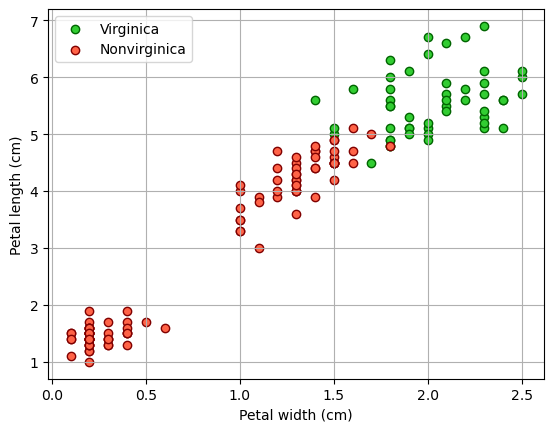

In [137]:
virginica = X[y == 1]
nonvirginica = X[y == 0]

plt.scatter(x=virginica[:, 1], y=virginica[:, 0], color="limegreen", edgecolor="darkgreen", label="Virginica")
plt.scatter(x=nonvirginica[:, 1], y=nonvirginica[:, 0], color="tomato", edgecolor="maroon", label="Nonvirginica")
plt.xlabel("Petal width (cm)")
plt.ylabel("Petal length (cm)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [178]:
def get_decision_boundary(pipeline):
    scaler = pipeline.named_steps["scaler"]
    svm = pipeline.named_steps["svm"]
    
    w = svm.coef_[0]
    b = svm.intercept_[0]

    decision_x = np.linspace(-10, 10, 100)
    decision_x_scaled = scaler.transform(np.c_[np.zeros_like(decision_x), decision_x])[:, 1]
    decision_y_scaled = -w[1] / w[0] * decision_x_scaled - b / w[0]
    decision_y = scaler.inverse_transform(np.c_[decision_y_scaled, np.zeros_like(decision_x)])[:, 0]

    return decision_x, decision_y

In [179]:
linear_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(loss="hinge", dual="auto", C=1.0, random_state=42)),
])

svc = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=1.0, kernel="linear", random_state=42)),
])

sgd_classifier = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SGDClassifier(loss="hinge", alpha=0.009, random_state=42)),
])

linear_svc.fit(X, y)
svc.fit(X, y)
sgd_classifier.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SGDClassifier(alpha=0.009, random_state=42))])

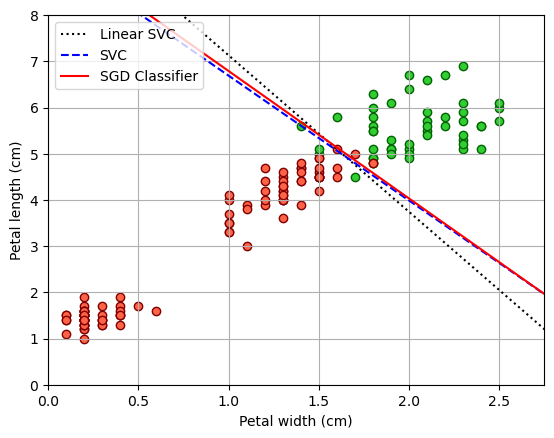

In [180]:
linear_svc_x, linear_svc_y = get_decision_boundary(linear_svc)
svc_x, svc_y = get_decision_boundary(svc)
sgd_classifier_x, sgd_classifier_y = get_decision_boundary(sgd_classifier)

plt.scatter(x=virginica[:, 1], y=virginica[:, 0], color="limegreen", edgecolor="darkgreen")
plt.scatter(x=nonvirginica[:, 1], y=nonvirginica[:, 0], color="tomato", edgecolor="maroon")

plt.plot(linear_svc_x, linear_svc_y, "k:", label="Linear SVC")
plt.plot(svc_x, svc_y, "b--", label="SVC")
plt.plot(sgd_classifier_x, sgd_classifier_y, "r-", label="SGD Classifier")

plt.xlabel("Petal width (cm)")
plt.ylabel("Petal length (cm)")
plt.legend(loc="upper left")
plt.axis([0, 2.75, 0, 8])
plt.grid(True)
plt.show()

## Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digis. You may want to tune the hyperparameters using small validation steps to speed up the process. What accuracy can you reach?

In [4]:
mnist = datasets.fetch_openml("mnist_784", version=1)

In [12]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

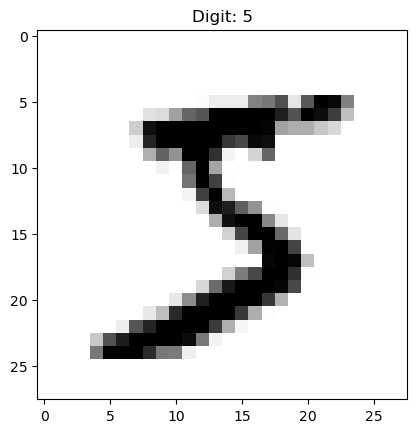

In [13]:
plt.imshow(mnist.data.loc[0].values.reshape(28, 28), cmap=plt.cm.binary)
plt.title(f"Digit: {mnist.target[0]}")
plt.show()

In [24]:
X = mnist.data.values
y = mnist.target.astype(int).values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_small, y_small = X_train[:1000], y_train[:1000]

In [45]:
param_distrib = {
    "C": uniform(1, 10),
    "gamma": loguniform(0.001, 0.1),
    "kernel": ["rbf"],
    "cache_size": [1000],
    "decision_function_shape": ["ovr"],
}

svc_clf = SVC()

rnd_search = RandomizedSearchCV(svc_clf, param_distrib, n_iter=100, cv=5, random_state=42, verbose=3)

rnd_search.fit(X_small, y_small)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=4.745401188473625, cache_size=1000, decision_function_shape=ovr, gamma=0.07969454818643935, kernel=rbf;, score=0.170 total time=   0.5s
[CV 2/5] END C=4.745401188473625, cache_size=1000, decision_function_shape=ovr, gamma=0.07969454818643935, kernel=rbf;, score=0.150 total time=   0.5s
[CV 3/5] END C=4.745401188473625, cache_size=1000, decision_function_shape=ovr, gamma=0.07969454818643935, kernel=rbf;, score=0.160 total time=   0.5s
[CV 4/5] END C=4.745401188473625, cache_size=1000, decision_function_shape=ovr, gamma=0.07969454818643935, kernel=rbf;, score=0.150 total time=   0.5s
[CV 5/5] END C=4.745401188473625, cache_size=1000, decision_function_shape=ovr, gamma=0.07969454818643935, kernel=rbf;, score=0.190 total time=   0.5s
[CV 1/5] END C=8.31993941811405, cache_size=1000, decision_function_shape=ovr, gamma=0.015751320499779727, kernel=rbf;, score=0.425 total time=   0.4s
[CV 2/5] END C=8.31993941811405

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=100,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fdaaf173680>,
                                        'cache_size': [1000],
                                        'decision_function_shape': ['ovr'],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fdaaf173a40>,
                                        'kernel': ['rbf']},
                   random_state=42, verbose=3)

In [46]:
print(f"Best parameters: {rnd_search.best_params_}")
print(f"Best estimator: {rnd_search.best_estimator_}")
print(f"Best score: {rnd_search.best_score_}")

Best parameters: {'C': 3.848404943774676, 'cache_size': 1000, 'decision_function_shape': 'ovr', 'gamma': 0.0011851515660043109, 'kernel': 'rbf'}
Best estimator: SVC(C=3.848404943774676, cache_size=1000, gamma=0.0011851515660043109)
Best score: 0.9059999999999999


In [47]:
best_model = rnd_search.best_estimator_
best_model.fit(X_train, y_train)

SVC(C=3.848404943774676, cache_size=1000, gamma=0.0011851515660043109)

In [49]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.92%


## Train an SVM regressor on the California housing dataset.

In [116]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [117]:
class MyLabelBinarizer(LabelBinarizer):
    def fit(self, X, y=None):
        return super().fit()

    def transform(self, X, y=None):
        return super().transform(X)

    def fit_transform(self, X, y=None):
        return super().fit(X).transform(X)

In [118]:
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.attribs].copy()

In [119]:
class ToNumpy(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.values

In [120]:
num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    ("to_numpy", ToNumpy()),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribs)),
    ("binarizer", MyLabelBinarizer()),
])

preprocessing = FeatureUnion([
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [121]:
X = housing.drop(["median_house_value"], axis=1)
y = housing["median_house_value"].copy().values

X = preprocessing.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
svr = SVR(kernel="rbf", C=1.0, gamma="scale", cache_size=1000)
svr.fit(X_train, y_train)

SVR(cache_size=1000)

In [123]:
svr.score(X_test, y_test)

-0.04291773281308253

In [124]:
y_pred = svr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

116903.7536029065

In [125]:
param_distrib = {
    "C": uniform(1, 10),
    "gamma": loguniform(0.001, 0.1),
    "kernel": ["rbf"],
    "cache_size": [1000],
}

svr = SVR()

rnd_search = RandomizedSearchCV(svr, param_distrib, n_iter=10, cv=5, random_state=42, verbose=3)

rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=4.745401188473625, cache_size=1000, gamma=0.07969454818643935, kernel=rbf;, score=-0.040 total time=  12.4s
[CV 2/5] END C=4.745401188473625, cache_size=1000, gamma=0.07969454818643935, kernel=rbf;, score=-0.033 total time=  12.5s
[CV 3/5] END C=4.745401188473625, cache_size=1000, gamma=0.07969454818643935, kernel=rbf;, score=-0.030 total time=  12.5s
[CV 4/5] END C=4.745401188473625, cache_size=1000, gamma=0.07969454818643935, kernel=rbf;, score=-0.016 total time=  12.4s
[CV 5/5] END C=4.745401188473625, cache_size=1000, gamma=0.07969454818643935, kernel=rbf;, score=-0.032 total time=  12.3s
[CV 1/5] END C=8.31993941811405, cache_size=1000, gamma=0.015751320499779727, kernel=rbf;, score=-0.045 total time=  12.3s
[CV 2/5] END C=8.31993941811405, cache_size=1000, gamma=0.015751320499779727, kernel=rbf;, score=-0.038 total time=  12.2s
[CV 3/5] END C=8.31993941811405, cache_size=1000, gamma=0.015751320499779727, 

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fdaa1b42300>,
                                        'cache_size': [1000],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fdaa217da00>,
                                        'kernel': ['rbf']},
                   random_state=42, verbose=3)

In [126]:
print(f"Best parameters: {rnd_search.best_params_}")
print(f"Best estimator: {rnd_search.best_estimator_}")
print(f"Best score: {rnd_search.best_score_}")

Best parameters: {'C': 4.745401188473625, 'cache_size': 1000, 'gamma': 0.07969454818643935, 'kernel': 'rbf'}
Best estimator: SVR(C=4.745401188473625, cache_size=1000, gamma=0.07969454818643935)
Best score: -0.030166954928640122


In [127]:
best_model = rnd_search.best_estimator_
y_pred = best_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

115510.97196610553